### Analyse the output file to retrive statistics on the run

In [10]:
import re
import ast
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import numpy as np
import os

In [11]:
output_file = "../cluster/outputs/attack_6313379.out"

In [12]:
def parse_output_file(output_file):
    """Parse the output file and extract relevant statistics."""
    print(f"Parsing output file: {output_file}")

    # Statistics from the output file
    with open(output_file, 'r') as file:
        content = file.readlines()
        processed_content = []
        for line in content:
            if '.-' in line:
                split_lines = line.replace('.-', '.\n-').splitlines()
                processed_content.extend(split_lines)
            else:
                processed_content.append(line)
        content = [line for line in processed_content if line.strip()]

    # Prepare lists to collect the results
    results = {
        "output_file": os.path.basename(output_file),
        "expected_percentages": Counter(),
        "best_b_percentages": Counter(),
        "tour_to_time": defaultdict(list),
        "true_b_std_percentages": defaultdict(dict),
        "best_candidate_std_percentages": defaultdict(dict),
        "block_sizes": defaultdict(list),
        "num_updates": defaultdict(list),
        "start_bkz": None,
        "total_time": 0,
        "total_train_samples": 0,
        "confusion_matrix": None,
        "classification_report": None,
        "success": False,
        "parameters": {},
        "num_matrices": None
    }

    # Extract dictionary from the first line using ast.literal_eval for safety
    parameters_line = content[0]
    results['parameters'] = ast.literal_eval(parameters_line.strip().split("Parameters: ")[1])

    # Extract number of matrices from the line "Attacking X matrices"
    matrices_line = content[1]
    num_matrices_match = re.search(r"Attacking (\d+) matrices*", matrices_line)
    results['num_matrices'] = int(num_matrices_match.group(1)) if num_matrices_match else None

    # Iterate through the file content and parse relevant data
    counter = 0
    current_tour = 0
    while counter < len(content):
        line = content[counter]
        if line.startswith("Tour"):
            # Extract tour number
            match = re.search(r'Tour (\d+)', line)
            current_tour = int(match.group(1)) if match else current_tour +1

            # Extract time from "Tour X completed after Y seconds."
            time_match = re.search(r'Tour \d+ completed after ([\d.]+) seconds', line)
            if time_match:
                tour_time = float(time_match.group(1)) / 3600 # Convert seconds to hours
                results['tour_to_time'][current_tour].append(tour_time)

            # Start scanning lines until next block or BKZ
            counter += 1
            while counter < len(content):
                subline = content[counter]

                # Match [BEST X% STD] True B in candidate set
                match_true_b = re.match(r"\[BEST (\d+)% STD\] Expected true B is best candidate: ([\d.]+)%", subline)
                if match_true_b:
                    percentile = int(match_true_b.group(1))
                    percent = float(match_true_b.group(2))
                    results['true_b_std_percentages'][current_tour][percentile] = percent
                    counter += 1
                    continue

                # Match [BEST X% STD] True B is the best candidate
                match_best = re.match(r"\[BEST (\d+)% STD\] True B is the best candidate: \d+ / \d+ \(([\d.]+)%\)", subline)
                if match_best:
                    percentile = int(match_best.group(1))
                    percent = float(match_best.group(2))
                    results['best_candidate_std_percentages'][current_tour][percentile] = percent
                    counter += 1
                    continue

                # Match general True B
                match_general_true_b = re.match(r"Expected true B is best candidate: ([\d.]+)%", subline)
                if match_general_true_b:
                    results['expected_percentages'][current_tour] = float(match_general_true_b.group(1))
                    counter += 1
                    continue

                # Match general Best candidate
                match_general_best = re.match(r"True B is the best candidate: \d+ / (\d+) \(([\d.]+)%\)", subline)
                if match_general_best:
                    results['total_train_samples'] = int(match_general_best.group(1))
                    results['best_b_percentages'][current_tour] = float(match_general_best.group(2))
                    counter += 1
                    continue

                # Match [BEST X% STD] True B in candidate set: N / M (P%)
                match_in_candidate = re.match(r"\[BEST (\d+)% STD\] True B in candidate set: (\d+) / (\d+) \(([\d.]+)%\)", subline)
                if match_in_candidate:
                    counter += 1
                    continue

                match_in_candidate = re.match(r"True B in candidate set: (\d+) / (\d+) \(([\d.]+)%\)", subline)
                if match_in_candidate:
                    counter += 1
                    continue

                # If no match, break to the next tour
                break
        elif line.startswith("- Running BKZ2.0"):
            if results['start_bkz'] is None:
                results['start_bkz'] = current_tour
            block_size_match = re.search(r"with block size (\d+)", line)
            if block_size_match:
                block_size = int(block_size_match.group(1))
                results['block_sizes'][current_tour].append(block_size)
        elif line.startswith("- Updated"):
            num_updates_match = re.search(r"Updated (\d+)/", line)
            if num_updates_match:
                results['num_updates'][current_tour].append(int(num_updates_match.group(1)))
        elif line.startswith("Reduction completed "):
            total_time_match = re.search(r"Reduction completed in (\d+\.\d+) seconds", line)
            if total_time_match:
                results['total_time'] += float(total_time_match.group(1))
        elif line.startswith("Confusion Matrix"):
            # Save lines for confusion matrix until classification report
            confusion_matrix_lines = []
            counter += 1
            while counter < len(content) and not content[counter].startswith("Classification Report"):
                confusion_matrix_lines.append(content[counter])
                counter += 1
            results['confusion_matrix'] = "".join(confusion_matrix_lines)
            counter -= 1
        elif line.startswith("Classification Report"):
            classification_report_lines = []
            counter += 1
            while counter < len(content) and not content[counter].startswith("#########"):
                classification_report_lines.append(content[counter])
                counter += 1
            results['classification_report'] = "".join(classification_report_lines)
            counter -= 1
        elif line.startswith("#########################################"):
            # End of attack
            break
        counter += 1

    results['success'] = True if results['confusion_matrix'] is not None else False

    return results

Parameters used:

In [13]:
results = parse_output_file(output_file)
# Extract parameters and statistics
parameters_dict = results['parameters']
matrix_shape = (parameters_dict.get('n', None), parameters_dict.get('k', None))
num_matrices = results['num_matrices']
total_time = results['total_time']
current_tour = max(results['tour_to_time'].keys(), default=0)
best_candidate_percentages = results['best_b_percentages']
success = results['success']
total_train_samples = results['total_train_samples']
best_candidate_std_percentages = results['best_candidate_std_percentages']

# Print the results
print("Parameters:")
params_to_print = ['n', 'q', 'k', 'secret_type', 'hw', 'reduction_factor', 'bkz_block_sizes', 'penalty']
for param in params_to_print:
    if param == 'hw':
        if 'hw' in parameters_dict and parameters_dict['hw'] == -1:
            continue
    if param in parameters_dict:
        print(f"- {param}: {parameters_dict[param]}")
print(f"Matrix shape: {matrix_shape}")
print(f"Number of matrices: {num_matrices}")
hours = int(total_time // 3600)
minutes = int((total_time % 3600) // 60)
seconds = int(total_time % 60)
print(f"Total time: {hours}:{minutes:02d}:{seconds:02d} ({total_time:.2f} seconds)")
print(f"Total tours: {current_tour}")
print(f"Total training samples: {total_train_samples}")
print(f"Final percentage of best candidate: {best_candidate_percentages[current_tour]:.2f}%")

# Calculate the best reached percentage in overall best candidates
best_overall = max(best_candidate_percentages.values(), default=0)
print(f"Best overall best candidate percentage: {best_overall:.2f}%")

# Calculate the best reached percentage in the percentiles best candidates
best_percentile = 0
for tour_data in best_candidate_std_percentages.values():
    if tour_data:
        best_percentile = max(best_percentile, max(tour_data.values()))
print(f"Best percentile best candidate percentage: {best_percentile:.2f}%")


if success:
    print("Attack success: ✅")
else:
    print("Attack success: ❌")

Parsing output file: ../cluster/outputs/attack_6313379.out
Parameters:
- n: 128
- q: 3329
- k: 1
- secret_type: binary
- reduction_factor: 0.875
- bkz_block_sizes: 20:42:2
- penalty: 3
Matrix shape: (128, 1)
Number of matrices: 125
Total time: 0:00:00 (0.00 seconds)
Total tours: 46
Total training samples: 28906
Final percentage of best candidate: 59.15%
Best overall best candidate percentage: 59.15%
Best percentile best candidate percentage: 69.25%
Attack success: ❌


In [14]:
print("Confusion Matrix:")
print(results['confusion_matrix'])
print("Classification Report:")
print(results['classification_report'])

Confusion Matrix:
None
Classification Report:
None


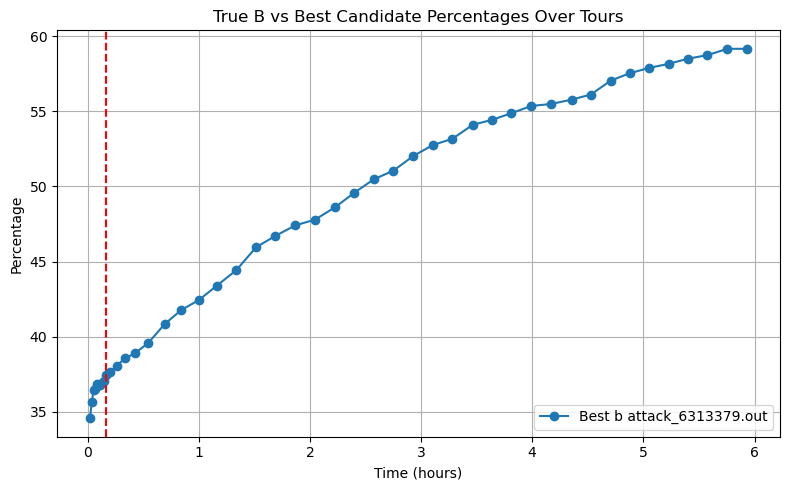

In [15]:
use_time = results['tour_to_time'] and len(results['tour_to_time']) > 0

x_axis_title = "Tour Number" if not use_time else "Time (hours)"

# Plotting
plt.figure(figsize=(8, 5))

tours = sorted(results['best_b_percentages'].keys())
tour_times = results['tour_to_time'].values()
best_b_percentages = results['best_b_percentages']

x_axis = tours if not use_time else tour_times
# Convert tour_times to a list of floats for indexing if using time as x-axis
if use_time:
    # tour_times is dict_values of lists, so flatten to a list of floats
    tour_times_list = [v[0] if isinstance(v, list) else v for v in tour_times]
    start_bkz = tour_times_list[results['start_bkz']]
    x_axis = tour_times_list
else:
    start_bkz = results['start_bkz']

best_candidate_values = [best_b_percentages[tour] for tour in tours]

plt.plot(x_axis, best_candidate_values, label=f"Best b {results['output_file']}", marker='o')

# Add vertical line where BKZ starts
if start_bkz is not None:
    plt.axvline(x=start_bkz, color='r', linestyle='--')

plt.title("True B vs Best Candidate Percentages Over Tours")
plt.xlabel(x_axis_title)
plt.ylabel("Percentage")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

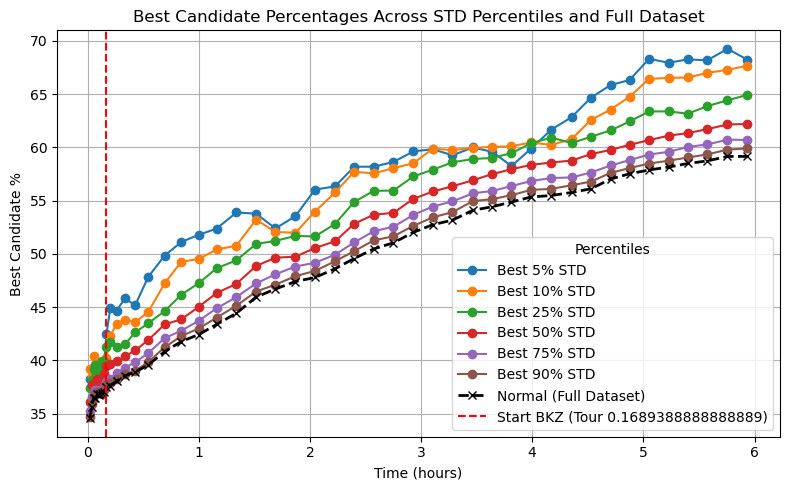

In [16]:
# Collect all unique STD percentiles seen across tours
all_percentiles = set()
for tour_data in best_candidate_std_percentages.values():
    all_percentiles.update(tour_data.keys())

all_percentiles = sorted(all_percentiles)
tours = sorted(set(best_candidate_std_percentages.keys()) | set(best_candidate_percentages.keys()))

plt.figure(figsize=(8, 5))

# Plot each STD percentile
for perc in all_percentiles:
    values = [
        best_candidate_std_percentages[tour].get(perc, None)
        for tour in tours
    ]
    valid = [(t, v) for t, v in zip(x_axis, values) if v is not None]
    if valid:
        valid_tours, valid_values = zip(*valid)
        plt.plot(valid_tours, valid_values, marker='o', label=f'Best {perc}% STD')

# Plot the normal best candidate % (full dataset)
normal_values = [
    best_candidate_percentages.get(tour, None) for tour in tours
]
valid_normal = [(t, v) for t, v in zip(x_axis, normal_values) if v is not None]
if valid_normal:
    valid_tours, valid_values = zip(*valid_normal)
    plt.plot(valid_tours, valid_values, marker='x', linestyle='--', linewidth=2, label='Normal (Full Dataset)', color='black')

# Optional BKZ line
if start_bkz is not None:
    plt.axvline(x=start_bkz, color='red', linestyle='--', label=f'Start BKZ (Tour {start_bkz})')

plt.title("Best Candidate Percentages Across STD Percentiles and Full Dataset")
plt.xlabel(x_axis_title)
plt.ylabel("Best Candidate %")
plt.grid(True)
plt.legend(title="Percentiles")
plt.tight_layout()
plt.show()



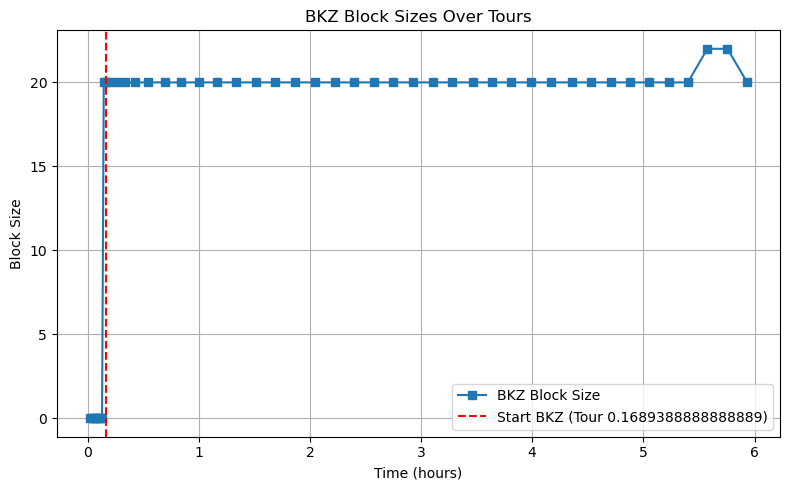

In [17]:
# Prepare block size values: use average if multiple in a tour, 0 if none
block_size_values = []
for tour in tours:
    sizes = results['block_sizes'][tour]
    #avg_size = sum(sizes) / len(sizes) if sizes else 0
    max_size = max(sizes) if sizes else 0
    block_size_values.append(max_size)

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(x_axis, block_size_values, label='BKZ Block Size', marker='s', linestyle='-')

# Add vertical line where BKZ starts
if start_bkz is not None:
    plt.axvline(x=start_bkz, color='red', linestyle='--', label=f'Start BKZ (Tour {start_bkz})')

plt.title("BKZ Block Sizes Over Tours")
plt.xlabel(x_axis_title)
plt.ylabel("Block Size")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


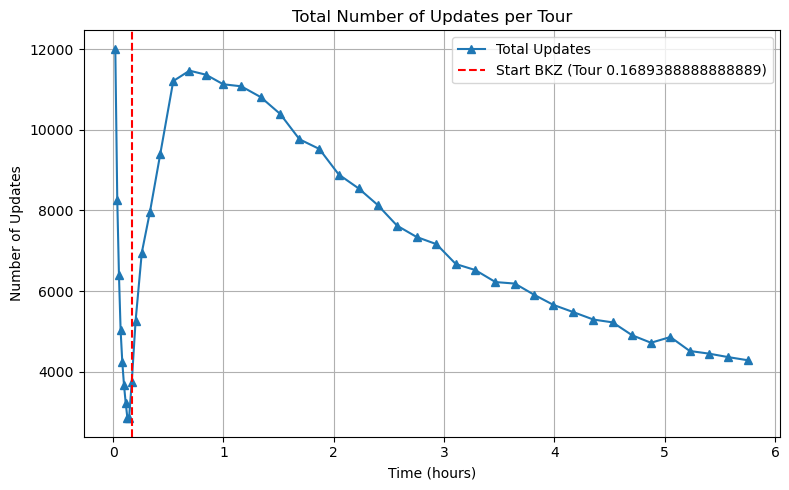

In [18]:
# Prepare update counts
num_updates = results['num_updates']
update_counts = [sum(num_updates.get(tour, [])) for tour in tours[:-1]]

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(list(x_axis)[:-1], update_counts, label='Total Updates', marker='^', linestyle='-')

# Add vertical line where BKZ starts
if start_bkz is not None:
    plt.axvline(x=start_bkz, color='red', linestyle='--', label=f'Start BKZ (Tour {start_bkz})')

plt.title("Total Number of Updates per Tour")
plt.xlabel(x_axis_title)
plt.ylabel("Number of Updates")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
